---
format: 
  html:
    toc: true
    code-fold: true
execute:
  echo: true
---

# Building Analysis

This analysis looks at the number of buildings located within the flood hazard area in the city of Philadelphia. Building data is downloaded from Open Street Maps. I determine the planning district and census block each building is located in and present summary maps showing the number of buildings in the flood hazard zone in each planning district and census block. 


# Import Packages

I import the packages I will use for this analysis. I used osmnx to download data from Open Street Maps. Pandas and geopandas are used to manipulate and transform my data. Altair and matplotlib are used to create visualizations. Pygris is used for downloading the census block group boundaries for Philadelphia.

In [1]:
import pandas as pd
import osmnx as ox
from matplotlib import pyplot as plt
import geopandas as gpd
import altair as alt
import pygris

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Get Data on Flood Plains

I get the flood hazard boundary data from the city's open data portal. The 100 year and 500 year flood plain are included as seperate layers. I perform some cleaning operations to both layers and then concatenate them together using the concat function in pandas.

In [3]:
flood_plain_100_year = gpd.read_file('https://opendata.arcgis.com/datasets/1d6d353ab50b4884b586c05ee2a661db_0.geojson').to_crs(6565)
flood_plain_500_year = gpd.read_file('https://opendata.arcgis.com/datasets/1e6f6315225544c88549478d25cc5181_0.geojson').to_crs(6565)

In [4]:
flood_plain_100_year.loc[flood_plain_100_year['FLOODWAY'] == 'FLOODWAY', ['ZONE']] = 'FLOODWAY'
flood_plain_100_year = flood_plain_100_year[['geometry','ZONE']].fillna('100 YEAR')
flood_plain_500_year['ZONE'] = '500 YEAR'
flood_plain_500_year = flood_plain_500_year[['geometry','ZONE']]
flood_plain = pd.concat([flood_plain_100_year,flood_plain_500_year])

In [5]:
planning_districts = gpd.read_file('https://opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson').to_crs(6565)

# Get Building Data

I carry out an analysis to determine the number of buildings that are located within the flood hazard zone. The building data is downloaded from open street maps using osmnx. The building data from OSM includes both polygons and points - in order to ensure that all the features in my buildings dataset are points I take the centroid of the building features. 

I then carry out a spatial join between the buildings and the boundaries of the flood hazard zone and create a new dataframe that only includes buildings whoose centroid is located in the flood hazard zone. I also use additional spatial joins to determine what planning district each building that is vulnerable to flooding is located in and the census block each building is located in.

In [6]:
buildings = ox.features_from_place("Philadelphia, PA", {"building": True})

In [7]:
buildings = buildings.to_crs(6565).reset_index()
buildings['geometry'] = buildings.geometry.centroid

In [9]:
philly_2020_block_groups = pygris.block_groups(state='42', county='101', year=2020).to_crs(6565)

In [10]:
buildings_f = buildings.sjoin(flood_plain,how='inner',predicate='within')
buildings_f.drop('index_right',axis=1,inplace=True)
buildings_f = buildings_f.sjoin(planning_districts[['DIST_NAME','geometry']],how='inner',predicate='within')
buildings_f.drop('index_right',axis=1,inplace=True)
buildings_f = buildings_f.sjoin(philly_2020_block_groups[['GEOID','geometry']],how='inner',predicate='within')

# Analysis by Planning District

The code below counts the number of buildings in each planning district that are located within the flood hazard zone.

In [11]:
pd_count = buildings_f.groupby('DIST_NAME')[['osmid']].count()
pd_count.rename({'osmid':'count'},inplace=True,axis=1)
planning_districts = planning_districts[['DIST_NAME','geometry']].merge(pd_count,on='DIST_NAME',how='left')

The map below is created using matplotlib and shows the number of buildings in the flood zone by planning district. The planning district with the larger number of buildings in the flood zone is the Southwest planning zone.

Text(0.5, 1.0, '# of Buildings in the Flood Hazard Zone by Planning District')

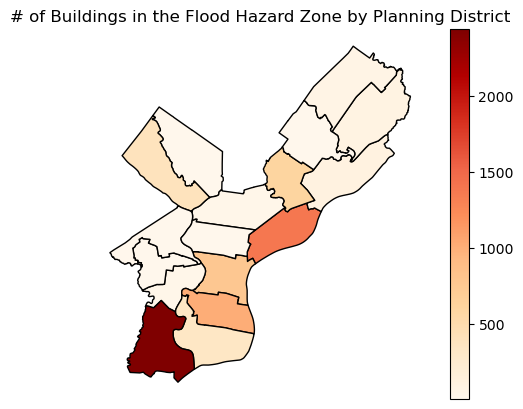

In [12]:
fig, ax = plt.subplots()

planning_districts.plot(ax=ax,column="count",legend=True,cmap='OrRd',edgecolor='black')

ax.set_axis_off()
ax.set_aspect("equal")

plt.title('# of Buildings in the Flood Hazard Zone by Planning District')


The chart below is created using altair and provides another way of visulizing the number of buildings located within the flood hazard zone. The color in the chart indicates the number of buildings in the floodway, in the 100 year flood plain, and the number in the 500 year floodplain. We can again observe that the largest number of buildings in the flood hazard zone are located in the Lower Southwest Planning District.

In [13]:
pd_count = buildings_f.groupby(['DIST_NAME','ZONE'],as_index=False)[['osmid']].count()
pd_count.rename({'osmid':'count'},inplace=True,axis=1)

domain1 = ['FLOODWAY','100 YEAR','500 YEAR']
range2 = ['red','blue','lightblue']

alt.Chart(pd_count).mark_bar().encode(
    alt.X('DIST_NAME').title('Planning District'),
    alt.Y('count').title('Building Count'),
    alt.Color('ZONE').scale(domain=domain1, range=range2),
    tooltip=['DIST_NAME','count','ZONE']
).properties(
    width=550,
    height=300,
    title='Number of Buildings Located in Flood Hazard Zone by Planning District'
)

alt.Chart(...)

# Analysis by Census Block Group

The analysis below examine the number of buildings in each census block that are located within the flood hazard zone. Census blocks that contain a large number of buildings in the flood hazard zone are located in southwest Philadelphia, in Center City along the Schuylkill river, and near the Delaware river in Fishtown.



In [14]:
pd_count = buildings_f.groupby('GEOID')[['osmid']].count()
pd_count.rename({'osmid':'count'},inplace=True,axis=1)
block_groups = philly_2020_block_groups[['GEOID','geometry']].merge(pd_count,on='GEOID',how='left')

Text(0.5, 1.0, '# of Buildings in the Flood Hazard Zone by Block Group')

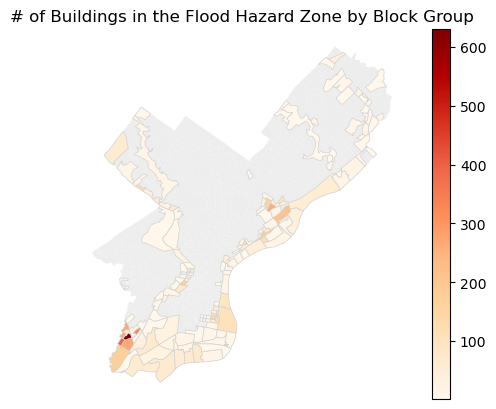

In [15]:
fig, ax = plt.subplots()

block_groups.plot(ax=ax,edgecolor='none',facecolor='#ededed')
block_groups.plot(ax=ax,column="count",legend=True,cmap='OrRd',edgecolor='lightgrey',linewidth=0.5)

ax.set_axis_off()
ax.set_aspect("equal")

plt.title('# of Buildings in the Flood Hazard Zone by Block Group')